# Large data processing

The biggest limitation to GPU-processing, beside its learning curve, is the memory space. It does not go higher than `32Gb` for commercial GPU. This can easily limits the maximum image size to process to `8Gb`, even less when we want to apply more complex algorithm requiring temporary steps.

This issue already exist outside of GPU-acceleartion and the solution is to tile our image and process each tile separatly to overcome the memory bottleneck. We can rely on the `dask` library to distribute our data accross our list of device, in the same way we would do on an HPC.

In [20]:
import dask.array as da
import dask.distributed as dd
import timeit
import numpy as np
import pyclesperanto as cle

import matplotlib.pyplot as plt

import zarr
from numcodecs import Blosc
from skimage.io import imread

### Load zarr data

In [17]:
image = imread("https://github.com/StRigaud/clesperanto_workshop_I2K24/raw/refs/heads/main/data/P1_H_C3H_M004_17-cropped.tif") # we only want 1 channel

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (500, 500)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = './P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

In [24]:
# darray = da.random.random((30, 20000, 20000), chunks=(30, 200, 200))
darray = da.from_zarr(zarr_filename, chunks=(2, 200, 200), name='zarray', compressor=compressor)
darray

/home/strigaud/Libraries/miniforge3/envs/skbe/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<zarray, shape=(2, 2000, 5000), dtype=uint8, chunksize=(2, 200, 200), chunktype=numpy.ndarray>

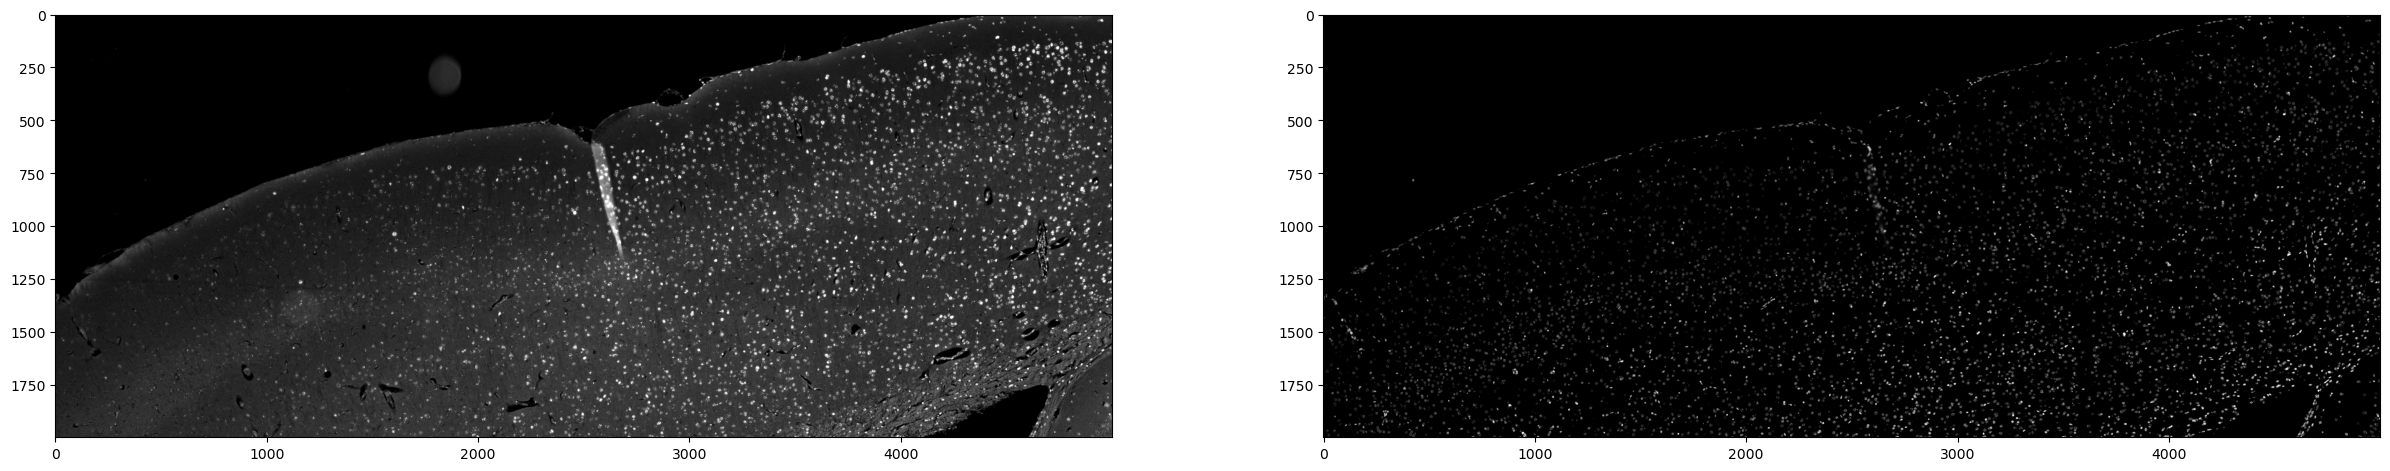

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))
axs[0].imshow(darray[0], cmap='gray')
axs[1].imshow(darray[1], cmap='gray')
plt.show()

In [26]:
nb_devices = len(cle.list_available_devices(device_type="gpu"))

cluster = dd.LocalCluster(n_workers=nb_devices, threads_per_worker=1, processes=False)
client = dd.Client(cluster)
print(client)

<Client: 'inproc://10.21.63.13/124417/16' processes=2 threads=2, memory=124.93 GiB>


/home/strigaud/Libraries/miniforge3/envs/skbe/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46615 instead
  warnings.warn(


In [27]:
workers = client.scheduler_info()['workers']
worker_dev_map = {worker: idx for idx, worker in enumerate(workers)}
for worker in workers:
    print(worker_dev_map[worker], "-", worker, ":" ,cle.select_device(worker_dev_map[worker], device_type="gpu").name)

0 - inproc://10.21.63.13/124417/19 : NVIDIA GeForce RTX 4090
1 - inproc://10.21.63.13/124417/21 : NVIDIA GeForce RTX 4090


### Define mini-Pipeline

In [28]:
def gpu_operation(image):
    # fetch the device associate to the worker
    worker = dd.get_worker()
    gpu_index = worker_dev_map[worker.address]
    device = cle.select_device(gpu_index, "gpu")
    # run processing on the worker device
    img_dev = cle.push(image, device=device)
    bged = cle.top_hat(img_dev, radius_x=30.0, radius_y=30.0, connectivity="box")
    labels = cle.voronoi_otsu_labeling(bged, spot_sigma=3.5)
    # return the results as numpy array
    return np.asarray(labels)

In [ ]:
# processed_image = da.map_overlap(gpu_operation, darray[1], dtype=darray.dtype, drop_axis=0, depth=[darray.shape[0], 40, 40])
processed_image = da.map_overlap(gpu_operation, darray[1], dtype=darray.dtype)
processed_image

dask.array<_trim, shape=(2000, 5000), dtype=uint8, chunksize=(200, 200), chunktype=numpy.ndarray>

### Execute processing

In [30]:
start = timeit.default_timer()
result = processed_image.compute()
end = timeit.default_timer()
print(f"Time to compute: {end - start} seconds")

Time to compute: 117.15837332297815 seconds


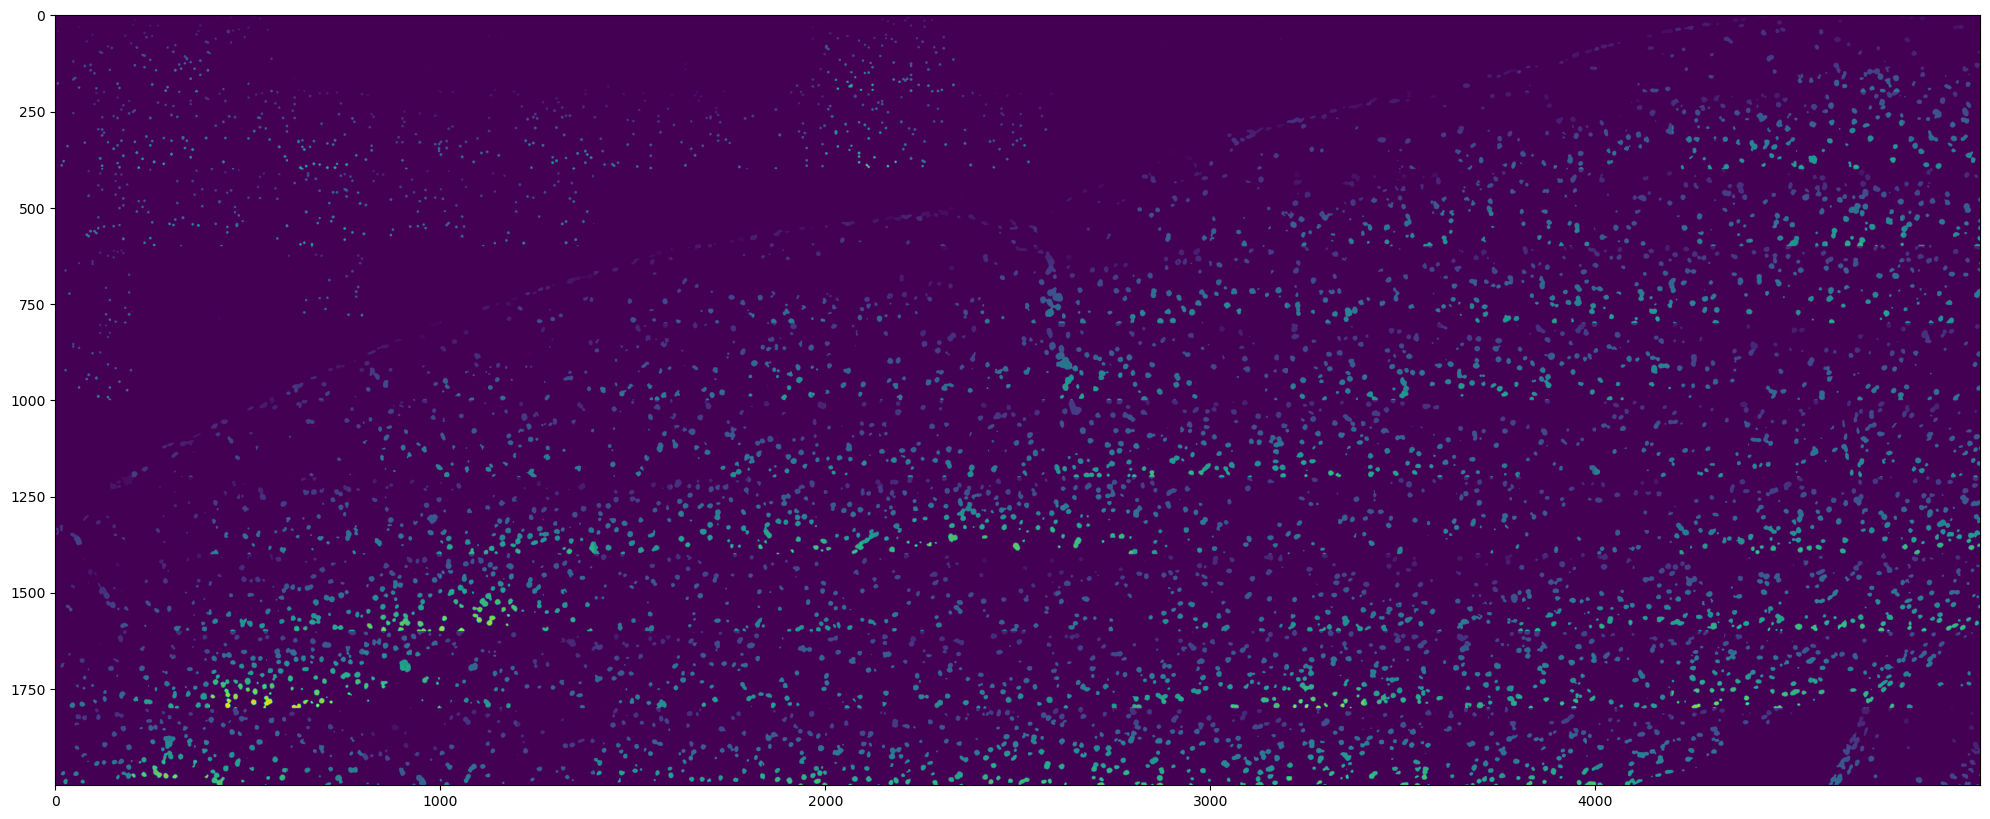

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.imshow(processed_image, cmap='viridis')
plt.show()